In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az

sns.set(style='whitegrid')

In [2]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/7-Bourbie&Zinszner-1985_PT.xls', 
                   sheet_name=1,
                   skiprows=[0,1,3],
                   usecols=['porosity', 'permeability']
                  )
     .dropna()
     )
#df

,porosity,permeability
0,3.1,0.075858
1,2.6,0.097724
2,3.1,0.097724
3,3.5,0.097724
4,3.9,0.097724
...,...,...
156,23.2,3548.133892
157,23.7,3548.133892
158,23.8,3162.277660
159,26.7,6456.542290


(array([51., 21.,  9.,  6., 14., 26., 18., 12.,  2.,  2.]),
 array([ 2.5,  5.1,  7.7, 10.3, 12.9, 15.5, 18.1, 20.7, 23.3, 25.9, 28.5]),
 <a list of 10 Patch objects>)

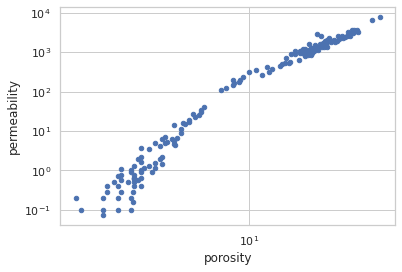

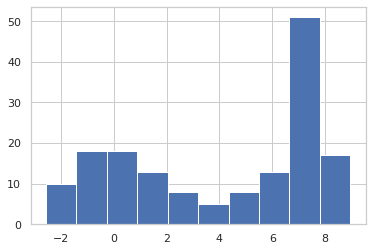

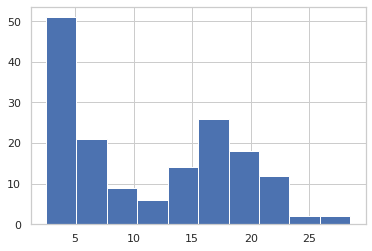

In [3]:
df.plot.scatter('porosity', 'permeability')
plt.gca().set(xscale='log', yscale='log')

plt.figure()
plt.hist(df.permeability.pipe(np.log))
plt.figure()
plt.hist(df.porosity)

In [4]:
df.porosity.min()

2.5

In [5]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
  
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    # Plotting
    ax1.plot(param)
    ax1.set(xlabel='samples', ylabel=param_name,
           title='Trace and Posterior Distribution for {}'.format(param_name)
           )
    ax1.axhline(mean, color='r', lw=2, linestyle='--')
    ax1.axhline(median, color='c', lw=2, linestyle='--')
    ax1.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax1.axhline(cred_max, linestyle=':', color='k', alpha=0.2)

    ax2.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax2)
    ax2.set(xlabel=param_name, ylabel='density')
    ax2.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax2.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax2.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
    ax2.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

    fig.tight_layout()
    plt.legend()


The equation we have been using is
$$k = k_0 (\phi - phi_c) ^ t$$

The log-transformed version is
$$\log k = \log k_0 + t \log(\phi - \phi_c)$$


## Two-level model

In [11]:
model_code = """
data {
    int<lower=1> N;
    vector[N] phi;
    vector[N] perm;
}
transformed data {
    vector [N] logperm = log(perm);
}
parameters {
    real <lower=0, upper=5> phi_critical[2];
    real <lower=0, upper=20> C_k[2];
    real <lower=0> t_exponent[2];
    real <lower=0> sigma_e[2];
    real <lower=0, upper=15> porosity_switch;
}

model {
    int j;
    phi_critical ~ normal(2,1);
    t_exponent ~ normal(3, 1);
    porosity_switch ~ cauchy(7,2);
    for (i in 1:N){
        if (phi[i] <= porosity_switch)
            j = 1;
        else
            j = 2;
        logperm[i] ~ normal(log(C_k[j]) + t_exponent[j] * log(phi[i] - phi_critical[j]), sigma_e[j]);
    }
}
generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    real mu;
    int j;
    for (i in 1:N){
        if (phi[i] <= porosity_switch)
            j = 1;
        else
            j = 2;
        mu = log(C_k[j]) + t_exponent[j] * log(phi[i] - phi_critical[j]);
        log_lik[i] = normal_lpdf(logperm[i] | mu, sigma_e[j]);
        y_hat[i] = exp(normal_rng(mu, sigma_e[j]));
    }
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a555b2d379a0767ca4b9222cc995e56 NOW.


In [12]:
data = {'N': len(df.porosity), 'phi':df.porosity, 'perm': df.permeability}
fit = model.sampling(
    data=data, iter=5000, chains=4, warmup=1000, thin=1, seed=42, #adapt_delta = 1.0,
)
#fit

In [21]:
var_names = ['C_k','phi_critical','t_exponent', 'porosity_switch']
az_fit = az.from_pystan(
    fit,
    posterior_predictive='y_hat',
    observed_data=["perm"], 
    log_likelihood = "log_lik",
    coords={"Class": ["Low porosity", "High porosity"]}, 
    dims = {"phi_critical": ["Class"], "C_k":["Class"], "t_exponent":["Class"]}
)
az.summary(az_fit, var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
C_k[0],0.042,0.036,0.002,0.109,0.002,0.002,232.0,232.0,171.0,87.0,1.01
C_k[1],5.165,1.400,2.541,7.790,0.146,0.103,92.0,92.0,93.0,149.0,1.05
phi_critical[0],1.383,0.310,0.807,1.944,0.023,0.016,180.0,180.0,186.0,223.0,1.01
phi_critical[1],4.368,0.200,3.991,4.741,0.020,0.015,96.0,95.0,95.0,147.0,1.04
t_exponent[0],3.469,0.535,2.507,4.477,0.040,0.028,182.0,177.0,185.0,166.0,1.01
t_exponent[1],2.208,0.095,2.028,2.389,0.010,0.007,95.0,95.0,94.0,152.0,1.05
porosity_switch,5.620,0.120,5.500,5.858,0.010,0.007,156.0,156.0,209.0,85.0,1.02


/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd9024dac0>,
      dtype=object)

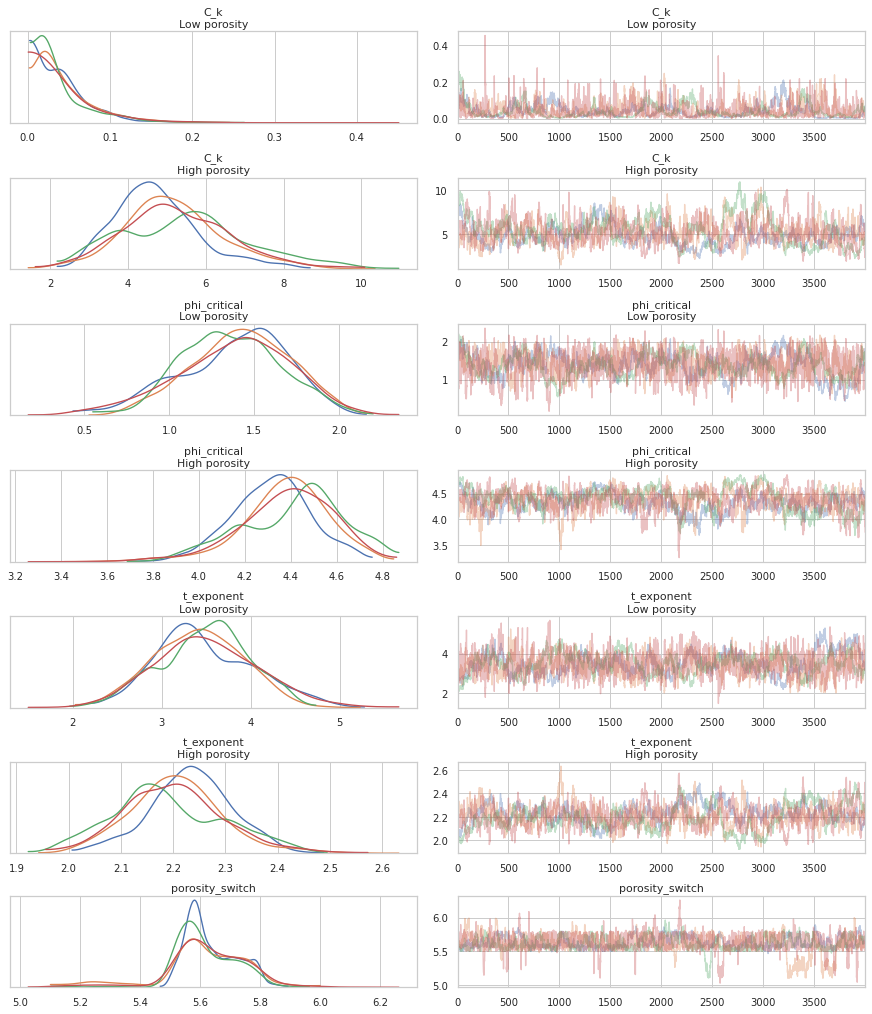

In [16]:
az.plot_trace(az_fit, var_names)

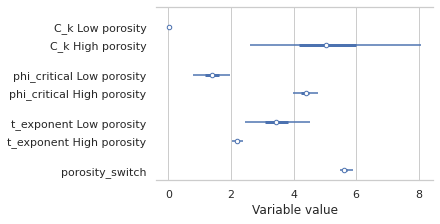

In [17]:
az.plot_forest(az_fit, var_names=var_names, figsize=(6,3), kind='forestplot', combined=True,
              credible_interval=0.95)
plt.gca().set(xlabel="Variable value", title='')
plt.savefig('bayes_figures/Fontainebleau_forest.png', dpi=300, bbox_inches='tight')

In [23]:
az.loo(az_fit), az.waic(az_fit)

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:526: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


(Computed from 16000 by 161 log-likelihood matrix
 
        Estimate       SE
 IC_loo   104.21    29.06
 p_loo     13.23        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 16000 by 161 log-likelihood matrix
 
         Estimate       SE
 IC_waic    96.63    26.77
 p_waic      9.44        -
 
 There has been a warning during the calculation. Please check the results.)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6b5327550>,
      dtype=object)

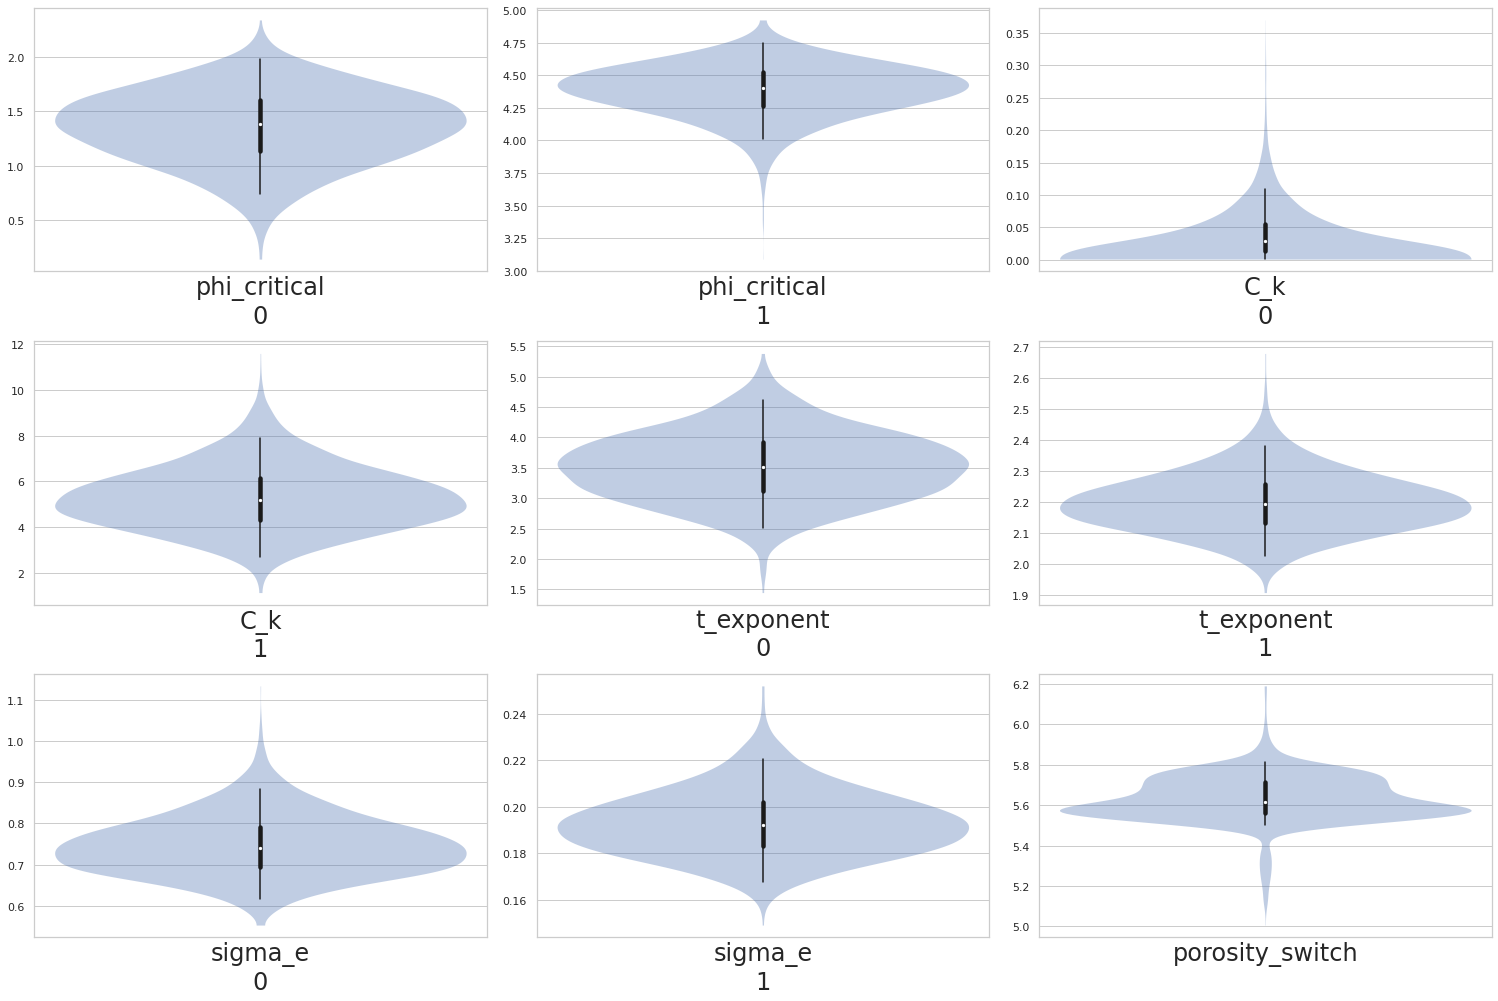

In [348]:
#fig, axes = plt.subplots(2,2, figsize=(7,5))
#az.plot_violin(fit, sharey=False, ax=axes)
#fig.tight_layout()
#for ax, xl in zip(axes.ravel(), ['$\phi_{te}$', '$C_k$', '$t$', '$\sigma_e$']):
#    ax.set(xlabel=xl)
#fig.savefig('bayes_figures/posterior_Fontainebleau.png', dpi=300)

az.plot_violin(fit, sharey=False)

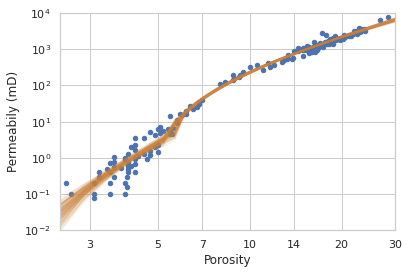

In [19]:
def log_posterior_examples(phi_predict, fit, num_examples=100):
    t = fit['t_exponent']
    phi_c = fit['phi_critical']
    perm0 = fit['C_k']
    phi_switch = fit['porosity_switch']
    samples = np.random.choice(len(t), num_examples)
    for e in samples:
        perm = np.zeros_like(phi_predict)
        perm[phi_predict <= phi_switch[e]] = perm0[e,0] * (phi_predict[phi_predict <= phi_switch[e]] - phi_c[e,0]) ** t[e,0]
        perm[phi_predict > phi_switch[e]] = perm0[e,1] * (phi_predict[phi_predict > phi_switch[e]] - phi_c[e,1]) ** t[e,1]
        yield perm

phi_fit = np.linspace(2.4, 30, 60)
for y in log_posterior_examples(phi_fit, fit, 100):
    plt.plot(phi_fit, y, color='peru', alpha=.1)
ax = plt.gca()
sc = df.plot.scatter('porosity', 'permeability', ax=ax)
#porosity_pred = np.linspace(2.5, 35)
#k_pred = 0.51 * (porosity_pred - 2.366) ** 2.91
#plt.plot(porosity_pred, k_pred, label='Curve fit', color='crimson')
ax.set(
    xlabel='Porosity',
    xscale='log',
    xlim=(2.4, 30),
    ylabel='Permeabily (mD)',
    yscale='log', 
    ylim=(1e-2, 1e4)
)
#plt.legend()
plt.xticks([3,5,7,10,14,20,30],[3,5,7,10,14,20,30]);
#sns.despine()
plt.savefig('bayes_figures/Fontainebleau_fit.png', dpi=300, bbox_inches='tight')

# One level model

In [297]:
model_code = """
data {
    int<lower=1> N;
    vector[N] phi;
    vector[N] perm;
}
transformed data {
    vector [N] logperm = log(perm);
}
parameters {
    real <lower=0, upper=2.5> phi_critical;
    real <lower=0, upper=2> C_k;
    real <lower=0> t_exponent;
    real <lower=0> sigma_e;
}
model {
    t_exponent ~ cauchy(3, 2);
    for (i in 1:N)
        logperm[i] ~ normal(log(C_k) + t_exponent * log(phi[i] - phi_critical), sigma_e);
}
"""
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc19bc0e676d438f6ce2d76766f4797d NOW.


In [298]:
data = {'N': len(df.porosity), 'phi':df.porosity, 'perm': df.permeability}
fit = model.sampling(
    data=data, iter=6000, chains=4, warmup=1000, thin=1, seed=42, #adapt_delta = 1.0,
)
fit

Inference for Stan model: anon_model_cc19bc0e676d438f6ce2d76766f4797d.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi_critical   1.57  3.4e-3   0.14   1.28   1.48   1.58   1.67   1.82   1591   1.01
C_k            0.03  2.2e-4   0.01   0.02   0.03   0.03   0.04   0.06   2464    1.0
t_exponent     3.89  2.7e-3   0.12   3.67   3.81   3.88   3.96   4.12   1834    1.0
sigma_e        0.57  3.7e-4   0.03   0.51   0.55   0.57   0.59   0.64   7693    1.0
lp__           11.7    0.02   1.47   7.98  10.99  12.03  12.76  13.52   5523    1.0

Samples were drawn using NUTS at Mon Jul  6 21:59:10 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

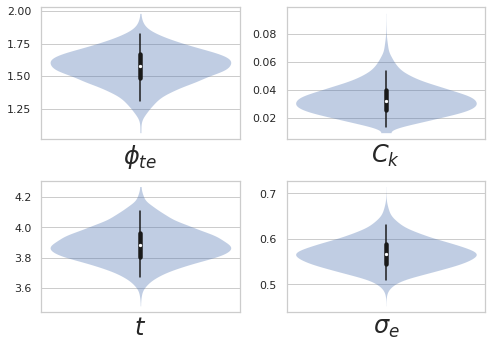

In [299]:
fig, axes = plt.subplots(2,2, figsize=(7,5))
az.plot_violin(fit, sharey=False, ax=axes) 
fig.tight_layout()
for ax, xl in zip(axes.ravel(), ['$\phi_{te}$', '$C_k$', '$t$', '$\sigma_e$']):
    ax.set(xlabel=xl)
#fig.savefig('bayes_figures/posterior_Fontainebleau.png', dpi=300)

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6ba6261c0>,
      dtype=object)

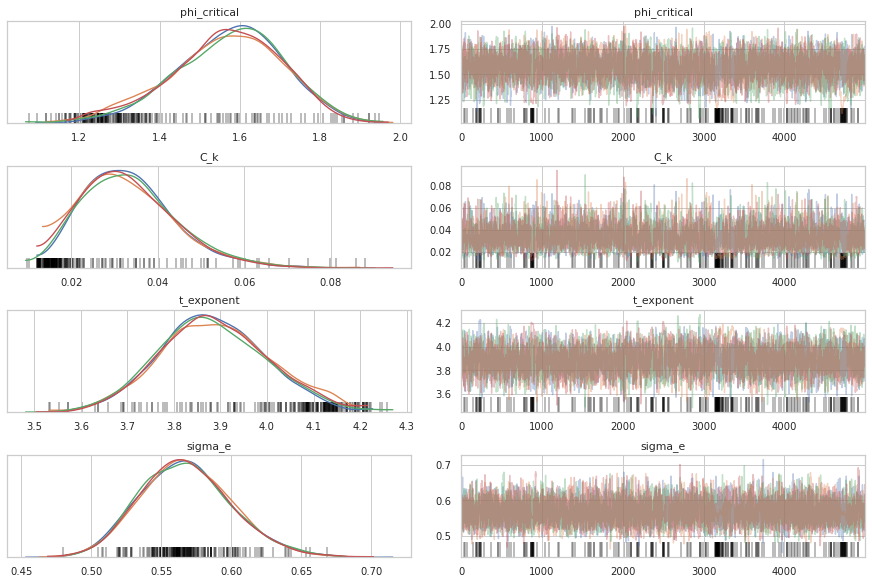

In [300]:
az.plot_trace(fit)

In [302]:
def log_posterior_examples(phi_predict, fit, num_examples=100):
    t = fit['t_exponent']
    phi_c = fit['phi_critical']
    perm0 = fit['C_k']
    samples = np.random.choice(len(t), num_examples)
    for e in samples:
        yield perm0[e] * (phi_predict - phi_c[e]) ** t[e]


for y in log_posterior_examples(phi_fit, fit, 1000):
    plt.plot(phi_fit, y, color='peru', alpha=.005)
ax = plt.gca()
sc = df.plot.scatter('porosity', 'permeability', ax=ax)
porosity_pred = np.linspace(2.5, 35)
k_pred = 0.51 * (porosity_pred - 2.366) ** 2.91
#plt.plot(porosity_pred, k_pred, label='Curve fit', color='crimson')
ax.set(
    xlabel='Porosity',
    xscale='log',
    ylabel='Permeabily (mD)',
    yscale='log', 
    ylim=(1e-2, 2e4)
)
#plt.legend()
plt.xticks([3,5,10,20,30],[3,5,10,20,30]);
plt.savefig('bayes_figures/Fontainebleau_fit.png', dpi=300, bbox_inches='tight')

[None, (0.01, 20000.0), None]

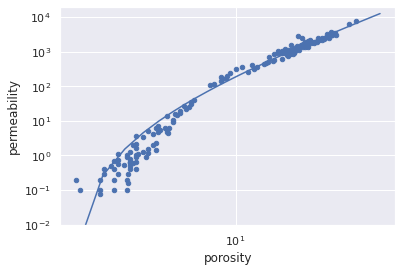

In [231]:
porosity_pred = np.linspace(2.5, 35)
k_pred = 0.51 * (porosity_pred - 2.366) ** 2.91
plt.plot(porosity_pred, k_pred)
ax = plt.gca()
df.plot.scatter('porosity', 'permeability', ax=ax)
ax.set(xscale='log', yscale='log', ylim=(1e-2, 2e4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe714695f40>,
      dtype=object)

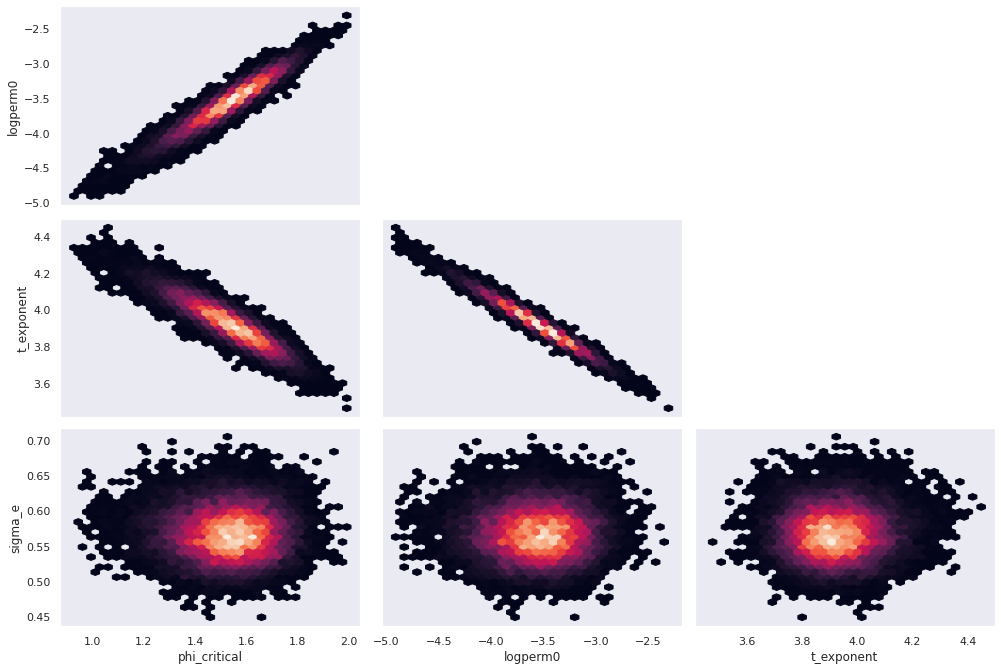

In [232]:
az.plot_pair(fit, kind="hexbin")